Author: Nicolas Legrand <nicolas.legrand@cfin.au.dk>

In [2]:
# Run this cell if you are using Google Colab
%%capture
! pip install hmmlearn

# Hidden Markov Models for M/EEG analysis.

In [3]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
from hmmlearn import hmm

# Simulate EEG signal

In [4]:
def simulate_single_channel(
    mode: str = 'short', sfreq: int = 256, seconds: float = 10.0,
    f1: float = 25.0, f2: float = 40.0, seed: int = 123
    )-> np.array:
    """Generate time serie with high-frequency bursts.

    Adapted from [1, 2].

    Parameters
    ----------
    mode : str
        Length of the simulation (`'short'` or `'long'`). If `'long'` is selected,
        the simulation is extended to eight times its lenght. Burst patterns
        are repeated in time but the noise is not. Default is set to `'short'`.
    sfreq : int
        Sampling frequency. Default is set to 256 Hz.
    seconds : int
        Length of recording. If mode is set to ´'long'´, this will be multiplied by 8.
    f1, f2 : int
        Frequency of the first and second burst (Hz).

    Return
    ------
    x : numpy.array
        Array containing the simulation.

    References
    ----------
    [1] Quinn, A. J., van Ede, F., Brookes, M. J., Heideman, S. G.,
        Nowak, M., Seedat, Z. A., … Woolrich, M. W. (2019). Unpacking
        Transient Event Dynamics in Electrophysiological Power Spectra.
        Brain Topography, 32(6), 1020–1034. https://doi.org/10.1007/s10548-019-00745-5

    [2] https://github.com/OHBA-analysis/Quinn2019_BurstHMM/blob/master/hmm_util_get_simulation.m
    """

    # A noise time-course is created by direct pole-placement. This creates a filte
    # with an approximately 1/f frequency profile.
    time_vect = np.linspace(0, seconds, seconds*sfreq)

    # the value in poly is the filter root. it can vary between 0 < x < 1 where 0
    # is white noise and 1 is an extremely sloped spectrum
    # a is then the denominator polynomial of a digital filter which is used to
    # create the signal
    noise = np.random.random(len(time_vect))
    b, a = signal.butter(1, 0.5)
    x = signal.filtfilt(b, a, noise)

    # Define burst occurances and durations
    seconds = 10
    np.random.seed(seed)
    starts = np.sort(
        np.round(np.array([0.1, 0.3, 0.6, 0.9]) * (seconds/2) * sfreq)).astype(int)
    starts2 = (starts + (seconds/2 * sfreq)).astype(int)
    duration = np.round((np.random.random(4) + 0.1) * sfreq).astype(int)

    # Create burst time-courses
    x2 = np.zeros(seconds*sfreq)
    x3 = np.zeros(seconds*sfreq)

    for st, dur in zip(starts, duration):
        # Add slow burst
        tmp = np.sin(2*np.pi*f1*time_vect[st:st+dur])
        tmp = tmp * signal.tukey(len(tmp), alpha=.25)
        x2[st:st+dur] = x2[st:st+dur] + tmp

    for st, dur in zip(starts2, duration):
        # Add fast burst
        tmp = np.sin(2*np.pi*f2*time_vect[st:st+dur])
        tmp = tmp * signal.tukey(len(tmp), alpha=.25)
        x3[st:st+dur] = x3[st:st+dur] + tmp

    # sum the noise and burst time-courses to create the final simulation
    amp2 = .3
    amp3 = .3

    if mode == 'long':
        # Extend simulation to eight times its lenght
        # Burst patterns are repeated in time but the noise is not
        noise = np.random.random(len(time_vect) * 8)
        x = signal.filtfilt(b, a, noise)
        x2 = np.tile(amp2 * x2, (1, 8))
        x3 = np.tile(amp3 * x3, (1, 8))
        time_vect = np.linspace(0, seconds * 8, seconds * sfreq * 8)

    elif mode == 'short':
        # Return short form of simulation
        noise = np.random.random(len(time_vect))
        x = signal.filtfilt(b, a, noise)
        x2 = np.tile(amp2 * x2, (1, 1))
        x3 = np.tile(amp3 * x3, (1, 1))
    else:
        raise ValueError('Mode should be ´short´ or ´long´')

    data = x + x2 + x3

    # Concatenate different parts of simulation
    x = np.vstack([data, x2[0, :], x3[0, :]])

    return x

## Single channel simulation

Here, we reproduce the simulation and testing procedure described in [1]. Transient bursting events at 25 and 40 Hz are incorporated into a noisy time series.

In [5]:
sfreq, seconds = 256, 10
x = simulate_single_channel('long', sfreq=sfreq, seconds=seconds)
time = np.arange(0, len(x[0, :])/256, 1/256)

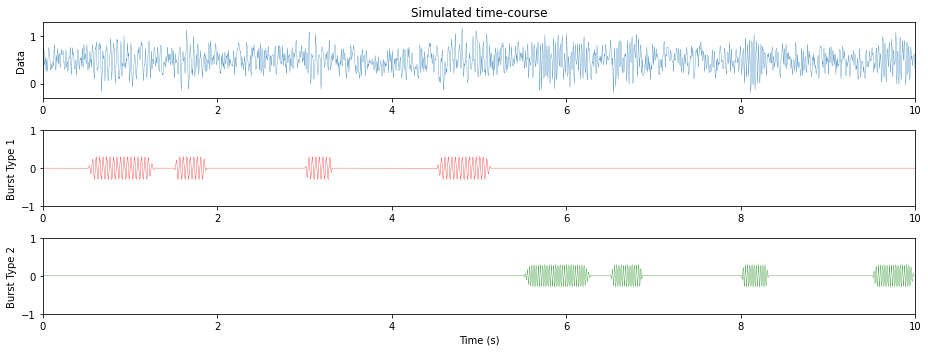

In [6]:
plt.figure(figsize=(13, 5))
plt.subplot(311)
plt.title('Simulated time-course')
plt.plot(time, x[0, :], linewidth=.3)
plt.ylabel('Data')
plt.xlim(0, 10)

plt.subplot(312)
plt.plot(time, x[1, :], 'r', linewidth=.3)
plt.ylim([-1, 1])
plt.ylabel('Burst Type 1')
plt.xlim(0, 10)

plt.subplot(313)
plt.plot(time, x[2, :], 'g', linewidth=.3)
plt.ylim([-1, 1])
plt.ylabel('Burst Type 2')
plt.xlabel('Time (s)')
plt.xlim(0, 10)
plt.tight_layout()

# Burst detection

2 methods are proposed to detect the high-frequency burst:
* The amplitude threshold method. After filtering the recording at a specified frequency, the envelope is used to detect bursts events based on an arbitrary threshold as proposed by [2] (here fixed as 2 * the median value).
* The envelope is used to fit a 2 states Hidden Markov Model and predict the probability of each state across time.

In [7]:
# Band-pass filter data (20-30 Hz) 
sos = signal.butter(5, [20, 30], 'bandpass', fs=256, output='sos')
filtered = signal.sosfilt(sos, x[0, :])

## Narrow-band amplitude

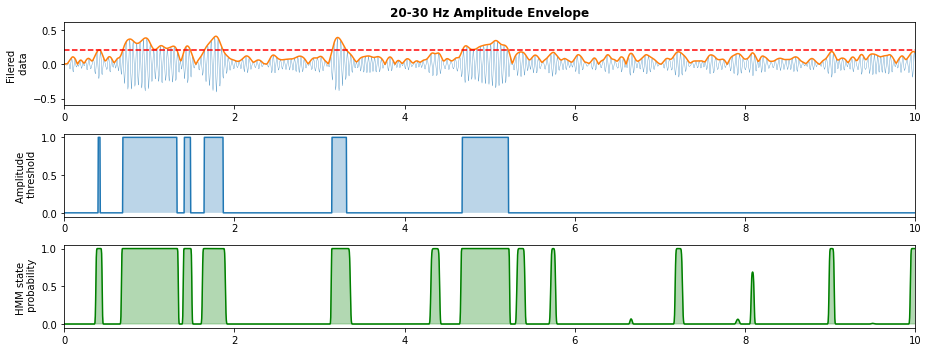

In [8]:
fig = plt.figure(figsize=(13, 5))
plt.subplot(311)
plt.title('20-30 Hz Amplitude Envelope', fontweight='bold')
plt.plot(time, filtered, label='signal', linewidth=.3)

analytic_signal = signal.hilbert(filtered)
amplitude_envelope = np.abs(analytic_signal)
plt.plot(time, amplitude_envelope, label='envelope')
plt.ylabel('Filered \n data')
plt.xlim(0, seconds)

# Here we generate an amplitude threshold using the Shin 2018 method
threshold = 2*np.median(amplitude_envelope)
plt.axhline(y=threshold, linestyle='--', color='r')

plt.subplot(312)
plt.plot(time, amplitude_envelope>threshold)
plt.fill_between(x=time, y1=amplitude_envelope>threshold, alpha=0.3)
plt.ylabel('Amplitude \n threshold')
plt.xlim(0, seconds)

# HHM estimation
remodel = hmm.GaussianHMM(n_components=2, covariance_type="full", n_iter=100)
remodel.fit(amplitude_envelope.reshape(-1, 1))
proba = remodel.predict_proba(amplitude_envelope.reshape(-1, 1))

plt.subplot(313)
plt.plot(time, proba[:, 1], 'g')
plt.fill_between(x=time, y1=proba[:, 1], alpha=0.3, color='g')
plt.ylabel('HMM state \n probability')
plt.xlim(0, seconds)
plt.tight_layout()

## Wider band amplitude

In [9]:
# Band-pass filter data (20-45 Hz) 
sos = signal.butter(5, [20, 45], 'bandpass', fs=256, output='sos')
filtered = signal.sosfilt(sos, x[0, :])

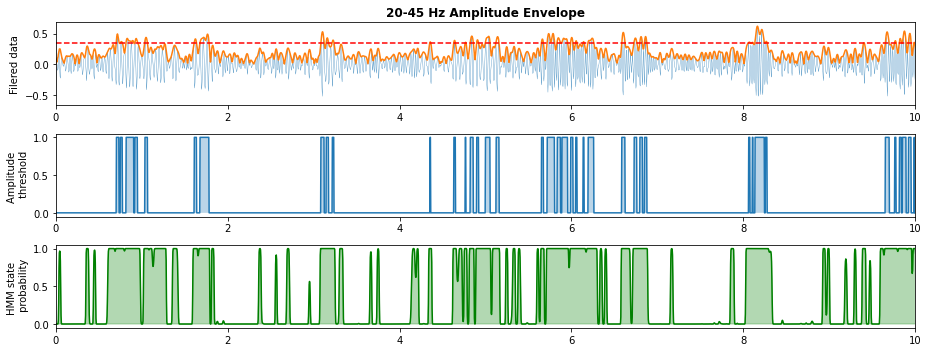

In [10]:
fig = plt.figure(figsize=(13, 5))
plt.subplot(311)
plt.title('20-45 Hz Amplitude Envelope', fontweight='bold')
plt.plot(time, filtered, label='signal', linewidth=.3)

analytic_signal = signal.hilbert(filtered)
amplitude_envelope = np.abs(analytic_signal)
plt.plot(time, amplitude_envelope, label='envelope')
plt.ylabel('Filered data')
plt.xlim(0, seconds)

# Here we generate an amplitude threshold using the Shin 2018 method
threshold = 2*np.median(amplitude_envelope)
plt.axhline(y=threshold, linestyle='--', color='r')

plt.subplot(312)
plt.plot(time, amplitude_envelope>threshold)
plt.fill_between(x=time, y1=amplitude_envelope>threshold, alpha=0.3)
plt.ylabel('Amplitude \n threshold')
plt.xlim(0, seconds)

# HHM estimation
remodel = hmm.GaussianHMM(n_components=2, n_iter=100)
remodel.fit(amplitude_envelope.reshape(-1, 1))
proba = remodel.predict_proba(amplitude_envelope.reshape(-1, 1))

# Find high frequency state
state1 = np.argmin(np.mean(proba, 0))

plt.subplot(313)
plt.plot(time, proba[:, state1], 'g')
plt.fill_between(x=time, y1=proba[:, state1], alpha=0.3, color='g')
plt.ylabel('HMM state \n probability')
plt.xlim(0, seconds)
plt.tight_layout()

# References

[1] Quinn, A. J., van Ede, F., Brookes, M. J., Heideman, S. G., Nowak, M., Seedat, Z. A., … Woolrich, M. W. (2019). Unpacking Transient Event Dynamics in Electrophysiological Power Spectra. Brain Topography, 32(6), 1020–1034. https://doi.org/10.1007/s10548-019-00745-5

[2] Shin, H., Law, R., Tsutsui, S., Moore, C. I., & Jones, S. R. (2017). The rate of transient beta frequency events predicts behavior across tasks and species. eLife, 6. https://doi.org/10.7554/elife.29086